# Predicting Newsletter Subscription Based on Session Behavior in Video Game Players

## DSCI 100 - Final Project Report

**Author:** Delia Zhang, Ryan Xie, Rachel McDonald, Oj Singh Dhillon   
**Date:** Fri, Apr 4th 

In [6]:
# Run this cell before continuing
library(dplyr)
library(repr)
library(tidyverse)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 10)

## Introduction

### Background

Video games today are more than just entertainment. They’re complex digital spaces where people explore, create, and connect with others. One game that really captures this is Minecraft, which gives players the freedom to build, roam, and play however they want. That makes it a great environment for studying how people interact in virtual worlds. At the University of British Columbia, a research team in the Department of Computer Science led by Dr. Frank Wood is using Minecraft to explore these questions. The group, known as PLAI (Pacific Laboratory for Artificial Intelligence), has set up a research server where every action a player takes is recorded. This creates a dataset full of patterns and behaviors. The big question we’re tackling in this project is: what can we learn from this data about the kinds of players who choose to subscribe to a game-related newsletter?

Subscribing to a newsletter might seem like a small thing, but it actually tells us a lot. It’s a sign that the player is interested in what’s happening beyond just the gameplay. Maybe they want updates, research findings, or even to stay connected to the community. For the researchers running the server, knowing what types of players are more likely to subscribe helps them plan ahead. They can focus their outreach on players who are more likely to stay involved or support the project over time.

In this project, we’re looking at what in-game actions or player traits predict whether someone subscribes to the newsletter. Specifically, we’re focusing on the relationship between session length and session frequency, and whether those factors can help predict if a player has subscribed. Newsletters are often used as a marketing and engagement tool, giving players updates about new features, events, or research findings. Knowing which players are more likely to sign up can help the research team and game developers tailor their outreach and strengthen community involvement. If certain patterns of gameplay are linked to higher interest in newsletters, those insights could be used to improve communication strategies and even shape how future research participants are recruited.

### Research Question

**Can session length and frequency predict whether a player subscribes to the newsletter?**

To explore whether session length and frequency can predict newsletter subscription, we are using gameplay data collected from the Minecraft research server. This dataset includes detailed information about each player's activity, such as how often they log in (session frequency) and how long they play during each session (session length). These two variables will serve as predictors, and the target variable is whether or not the player subscribed to the game-related newsletter. To analyze this relationship, we are using a K-Nearest Neighbors (KNN) classification model, which allows us to identify patterns by comparing each player to others with similar behavior. By training the model on the existing data, we aim to see whether certain play habits are linked to a higher chance of subscribing. If a clear pattern exists, the results could help the research team identify and engage with players who are most likely to stay connected to the project.

In [7]:
# Load datasets
players <- read.csv("https://raw.githubusercontent.com/ryanraen/dsci-100-term-project/refs/heads/main/data/players.csv")
sessions <- read.csv("https://raw.githubusercontent.com/ryanraen/dsci-100-term-project/refs/heads/main/data/sessions.csv")

# View first 6 rows of datasets
head(players)
head(sessions)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### Dataset Description

The data is composed of two primary CSV files:
- **players.csv**: Contains demographic and game engagement data for 196 individuals. Variables include:
  - `experience`: Player's self-rated experience level (e.g., Pro, Veteran, Amateur)
  - `subscribe`: Boolean indicator of newsletter subscription
  - `hashedEmail`: An anonymized player identifier
  - `played_hours`: Total hours the player has spent in-game
  - `name`: Player’s given name
  - `gender`: Gender identity
  - `Age`: Age in years

- **sessions.csv**: Contains 1,535 individual game session logs, with the following variables:
  - `hashedEmail`: The same anonymized player identifier as in `players.csv`
  - `start_time`, `end_time`: Session timestamps (character format)
  - `original_start_time`, `original_end_time`: Session timestamps in UNIX format

## Variables & Data Types

### Players data types
It includes 7 variables:
- `experience` – Character type
- `subscribe` – Logical type (TRUE/FALSE)
- `hashedEmail` – Character type
- `played_hours` – Numeric type
- `name` – Character type
- `gender` – Character type
- `Age` – Integer type

### Sessions data types
It includes 5 variables:
- `hashedEmail` – Character type
- `start_time` – Character type
- `end_time` – Character type
- `original_start_time` – Numeric type
- `original_end_time` – Numeric type

In [8]:
# Get data types for each dataset in a table format
players_types <- data.frame(
  variable = colnames(players),
  data_type = map_chr(players, class))

sessions_types <- data.frame(
  variable = colnames(sessions),
  data_type = map_chr(sessions, class))

players_types
sessions_types

,variable,data_type
,<chr>,<chr>
experience,experience,character
subscribe,subscribe,logical
hashedEmail,hashedEmail,character
played_hours,played_hours,numeric
name,name,character
gender,gender,character
Age,Age,integer


,variable,data_type
,<chr>,<chr>
hashedEmail,hashedEmail,character
start_time,start_time,character
end_time,end_time,character
original_start_time,original_start_time,numeric
original_end_time,original_end_time,numeric


## Variable Descriptions

### Players variables
This dataset contains general information about each player:
- `experience` – Describes how experienced a player is
- `subscribe` – Indicates whether the player subscribed to the newsletter (TRUE or FALSE)
- `hashedEmail` – A hashed version of the player's email address, used as a unique identifier
- `played_hours` – The total amount of time the player has spent in-game, measured in hours
- `name` – The player’s in-game name
- `gender` – The player’s gender
- `Age` – The age of the player

### Sessions variables
This dataset records specific gameplay sessions for each player:
- `hashedEmail` – Matches players across datasets using their hashed email address
- `start_time` – The session’s start time in character format
- `end_time` – The session’s end time in character format
- `original_start_time` – The session’s start time as a UNIX timestamp
- `original_end_time` – The session’s end time as a UNIX timestamp

In [9]:
# Creating a variable description table
players_variables <- data.frame(
  Variable = colnames(players),
  Description = c(
    "How experienced a player is",
    "Newsletter subscription status",
    "Hashed email address",
    "Total playtime (in hours)",
    "Player name",
    "Player gender",
    "Player age"))

sessions_variables <- data.frame(
  Variable = colnames(sessions),
  Description = c(
    "Hashed email address",
    "Session start time",
    "Session end time",
    "Session start time from UNIX",
    "Session end time from UNIX"))

players_variables
sessions_variables

Variable,Description
<chr>,<chr>
experience,How experienced a player is
subscribe,Newsletter subscription status
hashedEmail,Hashed email address
played_hours,Total playtime (in hours)
name,Player name
gender,Player gender
Age,Player age


Variable,Description
<chr>,<chr>
hashedEmail,Hashed email address
start_time,Session start time
end_time,Session end time
original_start_time,Session start time from UNIX
original_end_time,Session end time from UNIX


## Summary Statistics & Observations

The `players` dataset provides a summary of the players dataset, focusing on two numeric variables: age and total playtime (measured in hours). The youngest player in the dataset is 8 years old, and the oldest is 50. The median age is 19, which means that half of the players are younger than 19 and half are older. The standard deviation for age is about 6.17 years, indicating that most players are within about 6 years of the average age. For total playtime, the minimum number of hours played is 0, while the maximum is 223.1 hours. The median playtime is very low—just 0.1 hours—suggesting that many players only played briefly. The standard deviation is quite high at 28.36 hours, which means there is a lot of variation in how much time different players spent in the game.

The `sessions` dataset summarizes the sessions dataset, which includes timestamps for when players started and ended their sessions. These times are recorded as UNIX timestamps (large numbers representing the number of milliseconds since January 1, 1970). The earliest session start time in the dataset is around 1.7124e+12, and the latest is 1.7273e+12. The median start time is 1.7192e+12. Similarly, the earliest and median end times are close in value. The timestamps range over several months, and the standard deviation of start and end times is about 3.5 billion in UNIX units, suggesting a broad distribution of activity across time.

In [10]:
# Number of observations and variables  
dataset_summary <- data.frame(
  dataset = c("Players", "Sessions"),
  observations = c(nrow(players), nrow(sessions)),
  variables = c(ncol(players), ncol(sessions)))

dataset_summary

dataset,observations,variables
<chr>,<int>,<int>
Players,196,7
Sessions,1535,5


In [11]:
# Players summary
players_summary <- players |>
  select(Age, played_hours) |>
  summarise(across(everything(), list(
    min = min,
    median = median,
    max = max,
    sd = sd
  ), na.rm = TRUE))

# Sessions summary
sessions_summary <- sessions |>
  select(original_start_time, original_end_time) |>
  summarise(across(everything(), list(
    min = min,
    median = median,
    max = max,
    sd = sd
  ), na.rm = TRUE))

players_summary
sessions_summary

Age_min,Age_median,Age_max,Age_sd,played_hours_min,played_hours_median,played_hours_max,played_hours_sd
<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,19,50,6.174667,0,0.1,223.1,28.35734


original_start_time_min,original_start_time_median,original_start_time_max,original_start_time_sd,original_end_time_min,original_end_time_median,original_end_time_max,original_end_time_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.7124e+12,1.7192e+12,1.72733e+12,3557491589,1.7124e+12,1.71918e+12,1.72734e+12,3552813134


## Data Issues and Considerations

Before modeling, several data quality issues were considered:
- **Missing values**: Both datasets contained a small number of NA values (2 each), which were removed.
- **Outliers**: Some players had extremely long or short playtimes or session lengths.
- **Encoding**: Categorical variables (e.g., experience, gender) were not used in this model but could be considered in future work.
- **Duplicates**: No duplicate rows were found.
- **Session timestamps**: Required conversion to extract session durations in minutes.
- **Class imbalance**: The majority of players *are* subscribed to a newsletter.

By combining both datasets using the `hashedEmail` identifier, we calculated two key behavioral features for each player:
- **Average session length**: Mean time spent per session
- **Total session count**: Number of distinct sessions played

These variables form the basis of our predictive analysis.

In [12]:
# Checking for missing values
missing_values <- data.frame(
  dataset = c("Players", "Sessions"),
  total_missing_values = c(sum(is.na(players)), sum(is.na(sessions))))

# Checking for duplicate rows
duplicate_rows <- data.frame(
  dataset = c("Players", "Sessions"),
  total_duplicates = c(sum(duplicated(players)), sum(duplicated(sessions))))

missing_values
duplicate_rows

dataset,total_missing_values
<chr>,<int>
Players,2
Sessions,2


dataset,total_duplicates
<chr>,<int>
Players,0
Sessions,0


In [19]:
# Drop missing values
players_clean <- players |> drop_na()
sessions_clean <- sessions |> drop_na()

In [20]:
# Create session duration in minutes
sessions_clean <- sessions_clean |>
  mutate(duration = as.numeric(difftime(
    as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"),
    as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
    units = "mins")))

# Summarize per player
session_summary <- sessions_clean |>
  group_by(hashedEmail) |>
  summarise(
    avg_session_length = mean(duration, na.rm = TRUE),
    num_sessions = n(),
    .groups = "drop")

session_summary

hashedEmail,avg_session_length,num_sessions
<chr>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000,2
⋮,⋮,⋮
fc0224c81384770e93ca717f32713960144bf0b52ff67639433a5c06a653a882,16.00000,1
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,80.00000,1
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15.46774,310


In [21]:
# Merge session data with player data
merged_data <- inner_join(players_clean, session_summary, by = "hashedEmail")

# Remove any remaining missing values
merged_data <- drop_na(merged_data)

head(merged_data)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age,avg_session_length,num_sessions
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778,27
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000,3
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000,1
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50.00000,1
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9.00000,1
6,Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,5.00000,1


 avg_session_length  num_sessions     played_hours          Age       
 Min.   :  5.00     Min.   :  1.00   Min.   :  0.000   Min.   : 8.00  
 1st Qu.: 10.00     1st Qu.:  1.00   1st Qu.:  0.100   1st Qu.:17.00  
 Median : 19.00     Median :  1.00   Median :  0.400   Median :19.00  
 Mean   : 32.85     Mean   : 12.45   Mean   :  9.313   Mean   :20.61  
 3rd Qu.: 46.00     3rd Qu.:  2.00   3rd Qu.:  1.500   3rd Qu.:22.50  
 Max.   :150.34     Max.   :310.00   Max.   :223.100   Max.   :50.00  

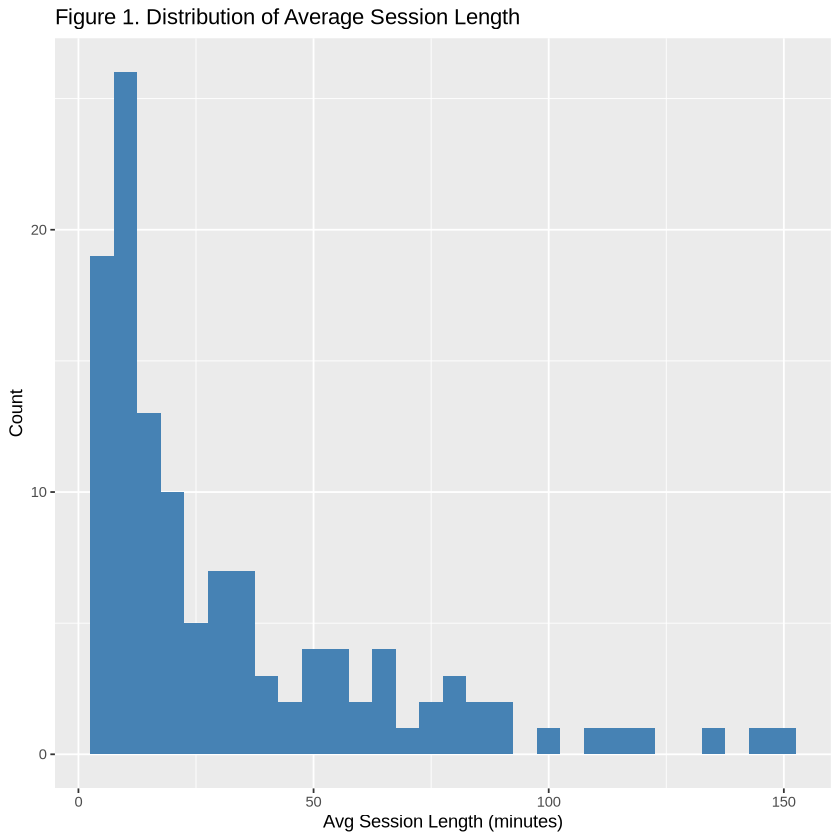

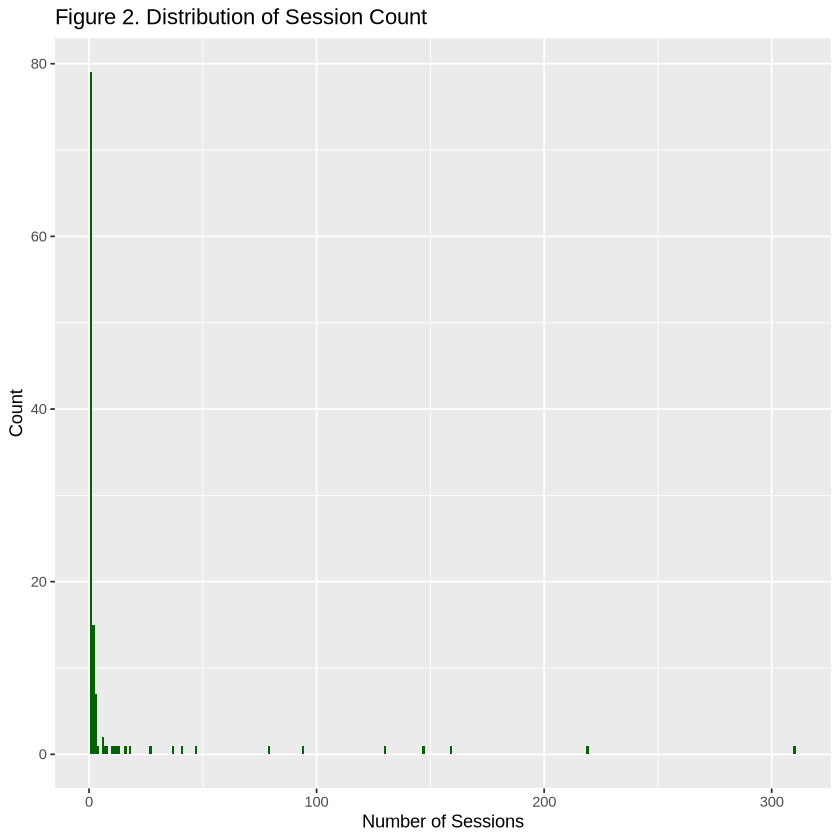

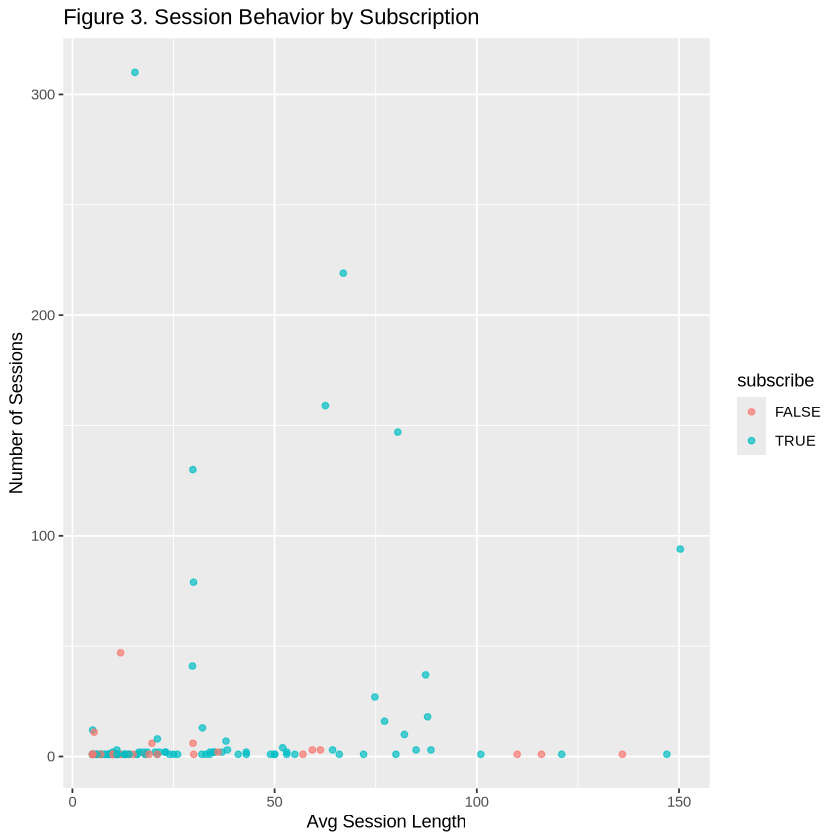

In [22]:
# Summary statistics
summary(merged_data[c("avg_session_length", "num_sessions", "played_hours", "Age")])

# Histogram of average session length
ggplot(merged_data, aes(x = avg_session_length)) +
  geom_histogram(binwidth = 5, fill = "steelblue") +
  labs(title = "Figure 1. Distribution of Average Session Length", x = "Avg Session Length (minutes)", y = "Count")

# Histogram of number of sessions
ggplot(merged_data, aes(x = num_sessions)) +
  geom_histogram(binwidth = 1, fill = "darkgreen") +
  labs(title = "Figure 2. Distribution of Session Count", x = "Number of Sessions", y = "Count")

# Scatterplot: avg session length vs. num sessions by subscription
ggplot(merged_data, aes(x = avg_session_length, y = num_sessions, color = subscribe)) +
  geom_point(alpha = 0.7) +
  labs(title = "Figure 3. Session Behavior by Subscription", x = "Avg Session Length", y = "Number of Sessions")

In [23]:
# Merge datasets and convert outcome to factor
merged_data <- players_clean |>
  inner_join(session_summary, by = "hashedEmail") |>
  drop_na() |>
  mutate(subscribe = as.factor(subscribe))

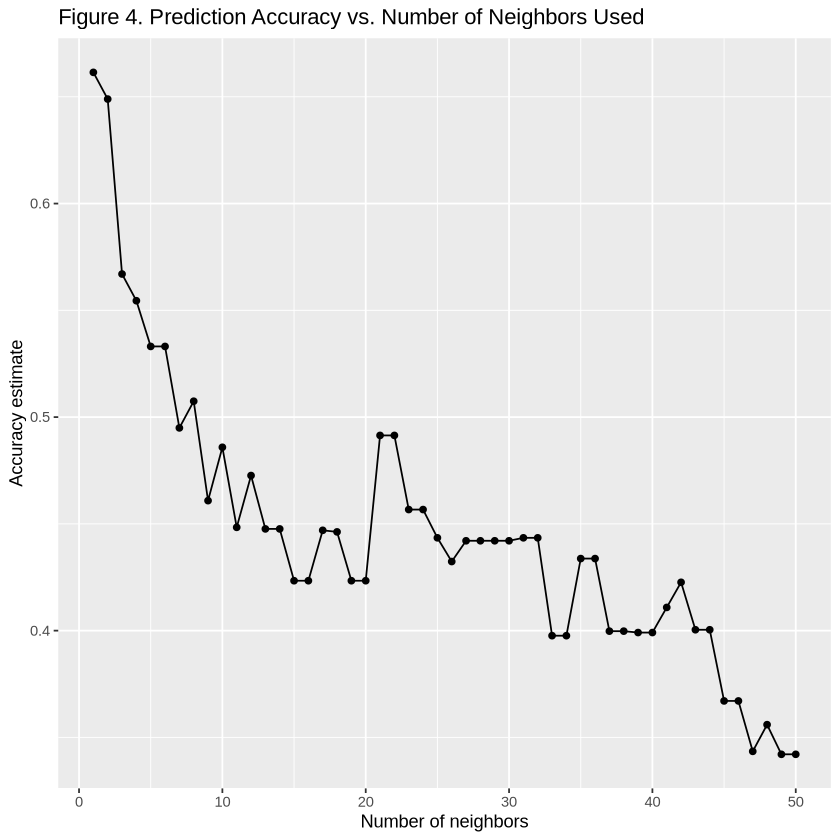

In [24]:
# Create recipe
knn_recipe <- recipe(subscribe ~ avg_session_length + num_sessions, data = merged_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  step_upsample(subscribe, over_ratio = 1, skip = TRUE)

# Create training/testing split
set.seed(123)
split <- initial_split(merged_data, prop = 0.7, strata = subscribe)
train_data <- training(split)
test_data <- testing(split)

# Define K-NN model
knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Workflow
knn_workflow <- workflow() |>
  add_model(knn_model) |>
  add_recipe(knn_recipe)

# Test K values 1-50
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# Apply 5 vfold cross validation
data_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

k_metrics <- knn_workflow |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Isolate accuracies for each K value
accuracies <- k_metrics |>
  filter(.metric == "accuracy")

# Visualize prediction accuracy and number of neighbors
best_k_vis <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 4. Prediction Accuracy vs. Number of Neighbors Used", x = "Number of neighbors", y = "Accuracy estimate")

best_k_vis

From the plot above, we can see that for:
- Small K values (1-10), there is a sharp dip in accuracy past K = 1 and there are fluctuations, suggesting overfitting.
- Mid-range K values (11-25), accuracies oscillate and fluctuate significantly, again implying overfitting.
- Higher K values (26-35), around K = 30 to K = 35, the accuracy is relatively stable, though still not very high.
- Large K values (36-50), there is a major drop in accuracy, potentially indicating underfitting as too many neighbors excessively generalizes the model.

Despite the somewhat unsatisfactory accuracy, there is a clear region of stability around K = 30 to K = 35. Hence, we will choose **K = 33** to achieve a balance between optimal accuracy, minimal fluctuations, and computational costs.

In [25]:
# Define new K-NN model with K = 18
best_knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fit new model
knn_fit <- workflow() |>
  add_model(best_knn_model) |>
  add_recipe(knn_recipe) |>
  fit(data = train_data)

# Predict and evaluate on test data
preds <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

# Metrics
metrics(preds, truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Confusion matrix
conf_mat(preds, truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.3947368


          Truth
Prediction FALSE TRUE
     FALSE     6   19
     TRUE      4    9